## Clustering de geopoints por DBSCAN


### Objetivos:
- Aplicar el algoritmo DBSCAN para obtener zonas de alta densidad de accidentes vehiculares en la CDMX.
    
### Desarrollo:
- Indicar un radio $\varepsilon=500$m que tendrá la vecindad. 
- Indicar el número mínimo de accidentes que tendrá la vecindad $min=5$ para ser conciderada una coordenada **significativa**  



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
df = pd.read_csv("data/incidentes-viales-c5-limpio.zip", sep="$", index_col=0)

In [7]:
df.tail()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,fecha_hora_cierre,fecha_hora_creacion
693675,C5/210228/09218,N,MIGUEL HIDALGO,accidente-motociclista,19.392430,-99.239100,URGENCIAS MEDICAS,LLAMADA DEL 911,MIGUEL HIDALGO,2,2021-02-28 22:50:09,2021-02-28 22:23:07
693688,C5/210228/09309,N,IZTAPALAPA,accidente-choque sin lesionados,19.349940,-99.066890,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,2,2021-02-28 23:44:19,2021-02-28 22:24:48
693689,C5/210228/09401,N,GUSTAVO A. MADERO,lesionado-atropellado,19.491660,-99.092150,URGENCIAS MEDICAS,LLAMADA DEL 911,GUSTAVO A. MADERO,2,2021-02-28 22:58:58,2021-02-28 22:45:49
693691,C5/210228/09417,A,AZCAPOTZALCO,accidente-choque sin lesionados,19.481660,-99.218560,EMERGENCIA,LLAMADA DEL 911,AZCAPOTZALCO,2,2021-02-28 23:48:19,2021-02-28 22:48:36
693692,IZ/210228/07916,A,XOCHIMILCO,accidente-choque sin lesionados,19.244195,-99.108017,EMERGENCIA,BOTÓN DE AUXILIO,XOCHIMILCO,2,2021-02-28 20:17:58,2021-02-28 19:46:33


#### Conversión de GPS a matriz de distancias y clustering con DBSCAN

In [9]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [10]:
coords = df[['latitud', 'longitud']].values
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels)) # Number of cluster with no noise 
# num_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Number of cluster with noise
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 44


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


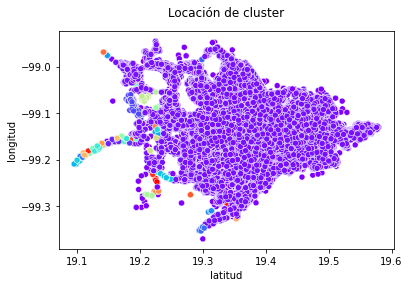

In [19]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('Locación de cluster', pad=15)
ax.set_xlabel('latitud')
ax.set_ylabel('longitud')

sns.scatterplot(df['latitud'], df['longitud'], ax=ax, hue=cluster_labels, palette='rainbow');
# sns.scatterplot(labels[:,0], labels[:,1], ax=ax, s=100, color='black');

ax.get_legend().remove()

#### Encontrar el punto más cercano a cada cluster

In [20]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [21]:
centermost_points = clusters[:len(clusters)-1].map(get_centermost_point)

In [23]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'latitud':lats, 'longitud':lons})

C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


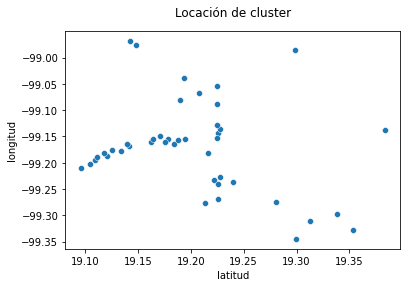

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('Locación de cluster', pad=15)
ax.set_xlabel('latitud')
ax.set_ylabel('longitud')

sns.scatterplot(rep_points['latitud'], rep_points['longitud'], ax=ax);
# sns.scatterplot(labels[:,0], labels[:,1], ax=ax, s=100, color='black');

In [23]:
# Guardamos las coordenadas de los puntos con mayor densidad 
rep_points.to_csv("most_dangerous_geop.csv")

#### Graficar Gmap

In [2]:
import gmaps

In [7]:
f = open("key.txt")
api_token = f.read() 
gmaps.configure(api_key=api_token)

##### Heatmap

In [32]:
#Cargamos labels 
dbscan_labels = pd.read_csv("data/dbscan_labels.csv", sep=",", index_col=0)

In [33]:
def labels_to_weights(label):
    if label == -1:
        return 0
    elif label == 0:
        return 1
    else:
        return label        

In [37]:
df['labels'] = dbscan_labels['label'].map(labels_to_weights) 

In [38]:
locations = df[['latitud', 'longitud']]
weights = dbscan_labels
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=df['labels']))
fig

Figure(layout=FigureLayout(height='420px'))

<img src="img/heatmap.png" alt="Maps">

##### Top puntos significativos

In [39]:
#Cargamos coordenadas significativas 
df = pd.read_csv("data/most_dangerous_geop.csv", sep=",", index_col=0)

In [40]:
top_dangerous_geopoints=tuple(zip(df['latitud'], df['longitud']))
fig = gmaps.figure()
markers = gmaps.marker_layer(top_dangerous_geopoints)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

<img src="img/map_most_icon_foto.png" alt="Maps">

Se observa que los puntos con mayor densidad de accidentes ocurren en carreteras. 

#### Reverse geocoding

In [44]:
import googlemaps

In [45]:
f = open("key.txt")
api_token = f.read() 
gsdk = googlemaps.Client(key=api_token)

In [ ]:
reverse_geocode_result = gsdk.reverse_geocode(top_dangerous_geopoints[0])
reverse_geocode_result


Con una geo decodificación se podría obtener dada un par de coordenas una descripción de las direcciones y avenidas. Sin embargo, ésta información tiene un costo asociado con el servidor de google. 
De obtener la información se podrían usar algoritmos de NPL

In [1]:
from geopy.geocoders import Nominatim

In [42]:
geolocator = Nominatim(user_agent="prueba")
for points in centermost_points:
    location = geolocator.reverse(f"{points[0]}, {points[1]}")
    print(f"Dirección: {location.address}")
    print(f'Datos:\n{location.raw["address"]} \n')

Dirección: 30, Calle Elvira, Nativitas, Benito Juárez, Ciudad de México, 03500, México
Datos:
{'house_number': '30', 'road': 'Calle Elvira', 'neighbourhood': 'Nativitas', 'city': 'Ciudad de México', 'postcode': '03500', 'country': 'México', 'country_code': 'mx'} 

Dirección: Calle Federal México-Cuernavaca, Tlalpan, San Miguel Topilejo, Ciudad de México, 14500, México
Datos:
{'road': 'Calle Federal México-Cuernavaca', 'neighbourhood': 'Tlalpan', 'town': 'San Miguel Topilejo', 'city': 'Ciudad de México', 'postcode': '14500', 'country': 'México', 'country_code': 'mx'} 

Dirección: Calle Federal México-Cuernavaca, Tlalpan, San Miguel Topilejo, Ciudad de México, 14500, México
Datos:
{'road': 'Calle Federal México-Cuernavaca', 'neighbourhood': 'Tlalpan', 'town': 'San Miguel Topilejo', 'city': 'Ciudad de México', 'postcode': '14500', 'country': 'México', 'country_code': 'mx'} 

Dirección: Avenida Fabián Flores, Barrio Centro, Milpa Alta, Ciudad de México, 12400, México
Datos:
{'road': 'Aveni

Dirección: Calle Tláloc, La Venta, Tlalpan, San Miguel Ajusco, Ciudad de México, 14700, México
Datos:
{'road': 'Calle Tláloc', 'neighbourhood': 'La Venta', 'town': 'San Miguel Ajusco', 'city': 'Ciudad de México', 'postcode': '14700', 'country': 'México', 'country_code': 'mx'} 

Dirección: Cerrada Huitziltepec, Xochimilco, San Miguel Topilejo, Ciudad de México, 14500, México
Datos:
{'road': 'Cerrada Huitziltepec', 'neighbourhood': 'Xochimilco', 'town': 'San Miguel Topilejo', 'city': 'Ciudad de México', 'postcode': '14500', 'country': 'México', 'country_code': 'mx'} 

Dirección: Carretera Federal México-Cuernavaca, Tlalpan, Parres (El Guarda), Ciudad de México, 14900, México
Datos:
{'road': 'Carretera Federal México-Cuernavaca', 'neighbourhood': 'Tlalpan', 'village': 'Parres (El Guarda)', 'city': 'Ciudad de México', 'postcode': '14900', 'country': 'México', 'country_code': 'mx'} 

Dirección: Autopista de Peaje Cuernavaca-México, Santa Cruz Chavarrieta, Xochimilco, San Miguel Topilejo, Ci